<h1 align=Center>Personalized cancer diagnosis</h1>

In [1]:
import streamlit as st
import os
import pandas as pd
import numpy as np
import time
import re
import random
import joblib
import math
from collections import Counter, defaultdict
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Importing utility functions from parent directory. Can't keep in pages as it creates menu in sidebar here.
import sys 
sys.path.insert(0, '../')
from utilities import *

# Setting seed for reproducibility
random_state = 42
np.random.RandomState(random_state)
np.random.seed(random_state)
random.seed(random_state)

[nltk_data] Error loading stopwords: <urlopen error [Errno 110]
[nltk_data]     Connection timed out>


In [2]:
# Noting the time of start of execution
start_time = time.time()

In [3]:
# Environment Variables & Data imports
TRAIN_DATA_DIR = "../train_data/" 
TEST_DATA_DIR = "../test_data/"
PROCESSED_DATA_DIR = "../preprocessed/"
MODELS_DIR = "../models/"

try:
    train_df = joblib.load(PROCESSED_DATA_DIR+"train_df.pkl")
    cv_df = joblib.load(PROCESSED_DATA_DIR+"cv_df.pkl")
    test_df = joblib.load(PROCESSED_DATA_DIR+"test_df.pkl")
    y_train = joblib.load(PROCESSED_DATA_DIR+"y_train.pkl")
    y_cv = joblib.load(PROCESSED_DATA_DIR+"y_cv.pkl")
    y_test = joblib.load(PROCESSED_DATA_DIR+"y_test.pkl")
    train_x_onehotCoding = joblib.load(PROCESSED_DATA_DIR+"train_x_onehotCoding.pkl")
    test_x_onehotCoding = joblib.load(PROCESSED_DATA_DIR+"test_x_onehotCoding.pkl")
    cv_x_onehotCoding = joblib.load(PROCESSED_DATA_DIR+"cv_x_onehotCoding.pkl")
    train_x_responseCoding = joblib.load(PROCESSED_DATA_DIR+"train_x_responseCoding.pkl")
    test_x_responseCoding = joblib.load(PROCESSED_DATA_DIR+"test_x_responseCoding.pkl")
    cv_x_responseCoding = joblib.load(PROCESSED_DATA_DIR+"cv_x_responseCoding.pkl")
    train_y = joblib.load(PROCESSED_DATA_DIR+"train_y.pkl")
    test_y = joblib.load(PROCESSED_DATA_DIR+"test_y.pkl")
    cv_y = joblib.load(PROCESSED_DATA_DIR+"cv_y.pkl")
    
except FileNotFoundError:
    print("Please check {0} path to validate if required file is present".format(PROCESSED_DATA_DIR))

all_model_metadata={}

In [4]:
# Utility
def get_impfeature_names(indices, text, gene, var, no_features, train_df):
    """
    Usage: get_impfeature_names(indices, text, gene, var, no_features)
    Returns: None
    >> for the given indices, we will print the name of the features and we will check whether the feature present in the test point text or not
    """
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    feature_presence_map = {"Gene": {},"Variantion": {},"Text": {}}
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                feature_presence_map['Gene'][i] = word
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                feature_presence_map['Variantion'][i] = word
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                feature_presence_map['Text'][i] = word
    
    pprint(">>> Out of the top {0} features {1} are present in query point".format(no_features,word_present))
    if word_present:
        pprint("Features present in Top {}".format(no_features),compact=True)
        pprint(feature_presence_map,compact=True)
        pprint("Numuber of features from Gene features: {0} | Variation: {1} | Text: {2}".\
               format(len(feature_presence_map['Gene']),len(feature_presence_map['Variantion']),len(feature_presence_map['Text'])))
    print("-"*50)
    # st.write(feature_presence_map)
    # st.caption("Out of the top {0} features {1} are present in query point".format(no_features,word_present))


<h3>1. Naive Bayes</h3>

<h5>1.1. Hyper parameter tuning</h5>

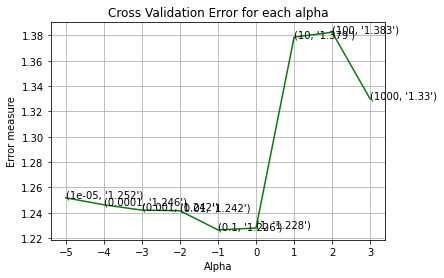

{'LogLoss': {'CV-loss': 1.226477674690059,
             'Test-loss': 1.3887805348287154,
             'Train-loss': 0.8630375158575515},
 'Tuning': {1e-05: 1.251833708615245,
            0.0001: 1.2463345823162688,
            0.001: 1.2421093844828208,
            0.01: 1.241627370299429,
            0.1: 1.226477674690059,
            1: 1.2279690216622192,
            10: 1.3786466045465502,
            100: 1.3825479550055728,
            1000: 1.3298268550391428}}


In [5]:
multinomial_dict = {}
alpha = [10**power for power in range(-5,4)]
cv_log_error_array = []
alpha_dict = {}

for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    alpha_dict[i] = log_loss(cv_y, sig_clf_probs)
multinomial_dict["Tuning"] = alpha_dict

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

multinomial_dict["LogLoss"] = loss_dict 
pprint(multinomial_dict,compact=True)

<h5>1.2. Testing the model with best hyper paramters</h5>

2022-12-19 16:06:12.095 
  command:

    streamlit run /home/kmistri/.local/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


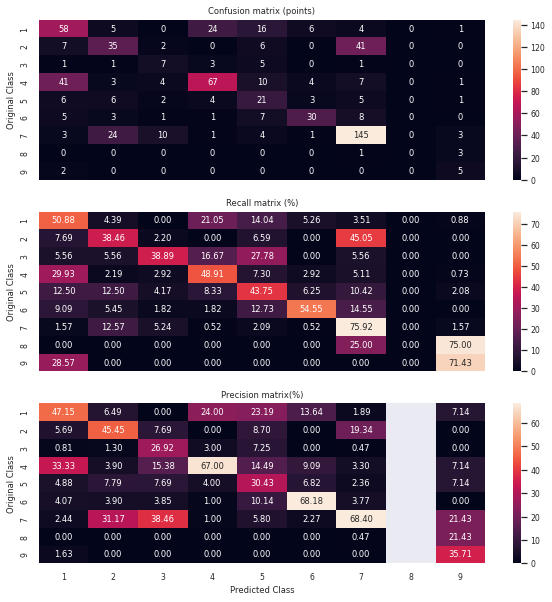

In [6]:
# Refer: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
best_parameters = {}
best_parameters['Alpha'] = best_alpha

clf = MultinomialNB(alpha=best_alpha)

# # Keep an eye for train_x & test_x for perticular problem
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           clf)
plot_confusion_matrix(test_y, pred_y)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
multinomial_dict["best_parameters"] = best_parameters

<h5>1.1.4. Feature Importance</h5>

In [7]:
# Final Model Training with best params
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Get classification points separately
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
multinomial_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h6>Correctly classified point</h6>

In [8]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)

Predicted Class :1
Class       1       2       3      4       5       6       7       8       9
Prob   0.5751  0.0821  0.0127  0.108  0.0418  0.0349  0.1376  0.0043  0.0034
Actual Class : 1
'>>> Out of the top 100 features 63 are present in query point'
'Features present in Top 100'
{'Gene': {},
 'Text': {11: 'function',
          13: 'protein',
          15: 'affect',
          16: 'type',
          17: 'one',
          18: 'binding',
          19: 'each',
          20: 'two',
          21: 'wild',
          22: 'the',
          23: 'reduced',
          24: 'sequence',
          27: 'into',
          28: 'amino',
          29: 'functions',
          31: 'loss',
          32: 'are',
          33: 'as',
          34: 'of',
          35: 'and',
          36: 'that',
          37: 'this',
          38: 'form',
          39: 'for',
          40: 'essential',
          41: 'structure',
          42: 'we',
          43: 'which',
          44: 'on',
          45: 'only',
          47: 'specif

<h6>Incorrectly classified point</h6>

In [9]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature,\
                     train_df)

Predicted Class : 1
Class       1       2       3      4       5       6       7       8       9
Prob   0.5751  0.0821  0.0127  0.108  0.0418  0.0349  0.1376  0.0043  0.0034
Actual Class : 5
--------------------------------------------------
'>>> Out of the top 100 features 0 are present in query point'
--------------------------------------------------


In [10]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_MultinomialNB.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_MultinomialNB.pkl")

multinomial_dict["Models"] = {"base_classifier" : MODELS_DIR[1:]+"base_MultinomialNB.pkl",\
                              "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_MultinomialNB.pkl"}
all_model_metadata["MultinomialNB"] = multinomial_dict

In [11]:
pprint(multinomial_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 3, 4, 5, 6, 7, 9, 10, 11, 14, 16,
                                            17, 18, 19, 20, 21, 22, 24, 25, 26,
                                            29, 30, 33, 34, 35, 36, 37, 38, 41,
                                            44, 46, 50, 55, 56, 59, 61, 62, 65,
                                            66, 68, 69, 72, 75, 76, 77, 78, 79,
                                            81, 84, 86, 88, 90, 91, 92, 94, 96,
                                            100, 101, 102, 103, 105, 107, 108,
                                            112, 113, 114, 116, 118, 122, 123,
                                            124, 127, 128, 129, 130, 131, 132,
                                            133, 137, 138, 144, 146, 147, 148,
                                            152, 153, 154, 158, 159, 160, 161,
                                            163, 169, 170, 171, 172, 173, 174,
                                            1

<h3>2. K-Nearest Neighbour Classification</h3>

<h5>2.1. Hyper parameter tuning</h5>

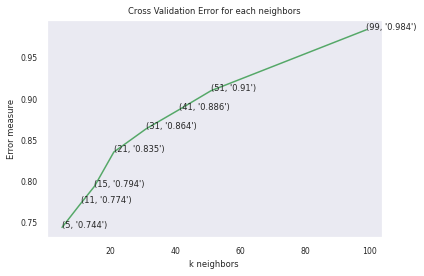

{'LogLoss': {'CV-loss': 0.7440579123882148,
             'Test-loss': 0.8854096505639446,
             'Train-loss': 0.3928796260587844},
 'Tuning': {5: 0.7440579123882148,
            11: 0.7742030614614316,
            15: 0.7937918865266659,
            21: 0.8354359906684621,
            31: 0.8636368732694989,
            41: 0.8864158583746085,
            51: 0.9097198897059763,
            99: 0.9836181520442074}}


In [12]:
knn_dict = {}
neighbors = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
hyperparam_dict = {}

for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    hyperparam_dict[i] = log_loss(cv_y, sig_clf_probs)
knn_dict["Tuning"] = hyperparam_dict

fig, ax = plt.subplots()
ax.plot(neighbors, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((neighbors[i],str(txt)), (neighbors[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each neighbors")
plt.xlabel("k neighbors")
plt.ylabel("Error measure")
plt.show()


best_neighbors = neighbors[np.argmin(cv_log_error_array)]

clf = KNeighborsClassifier(n_neighbors=best_neighbors)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

knn_dict["LogLoss"] = loss_dict 
pprint(knn_dict,compact=True)


<h5>2.2. Testing the model with best hyper paramters</h5>

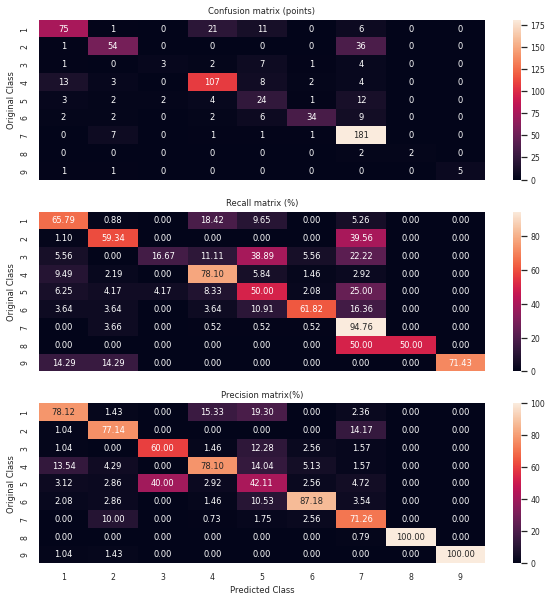

In [13]:
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
best_parameters = {}
best_parameters['n_neighbors'] = best_neighbors

clf = KNeighborsClassifier(n_neighbors=best_neighbors)

# Keep an eye for train_x & test_x for perticular problem
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_responseCoding, \
                                                                                           train_y, \
                                                                                           test_x_responseCoding, \
                                                                                           test_y, \
                                                                                           clf)
plot_confusion_matrix(test_y, pred_y)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
knn_dict["best_parameters"] = best_parameters

<h5>2.3.Classification details</h5>

In [14]:
# Model fitting
clf = KNeighborsClassifier(n_neighbors=best_neighbors)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_responseCoding)
total_test_points = test_x_responseCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
knn_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h6>Sampling correct point</h6>

In [15]:
test_point_index = random.choice(correctly_classified_point_idxs)
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), best_neighbors)

print("Optimal value for nearest neighbors knn is {0} \nThe nearest neighbours of the test points belongs to classes \n>>> {1}".\
      format(best_neighbors,Counter(train_y[neighbors[1][0]])))
print("Predicted Class : {0}".format(predicted_cls[0]))
print("Actual Class : {0}".format(test_y[test_point_index]))

Optimal value for nearest neighbors knn is 5 
The nearest neighbours of the test points belongs to classes 
>>> Counter({7: 5})
Predicted Class : 2
Actual Class : 7


<h5>Sampling incorrect point </h5>

In [16]:
test_point_index = random.choice(misclassified_point_idxs)

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), best_neighbors)
print("Optimal value for nearest neighbors knn is {0} \nThe nearest neighbours of the test points belongs to classes \n>>> {1}".\
      format(best_neighbors,Counter(train_y[neighbors[1][0]])))
print("Predicted Class : {0}".format(predicted_cls[0]))
print("Actual Class : {0}".format(test_y[test_point_index]))

Optimal value for nearest neighbors knn is 5 
The nearest neighbours of the test points belongs to classes 
>>> Counter({2: 3, 6: 1, 7: 1})
Predicted Class : 2
Actual Class : 7


In [17]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_KNN.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_KNN.pkl")

knn_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_KNN.pkl",\
                      "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_KNN.pkl"}

all_model_metadata["KNN"] = knn_dict

In [18]:
pprint(knn_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 14,
                                            16, 17, 18, 20, 21, 22, 23, 24, 25,
                                            26, 27, 28, 29, 31, 32, 33, 36, 37,
                                            38, 41, 42, 44, 45, 46, 48, 49, 50,
                                            51, 52, 53, 55, 56, 59, 61, 62, 65,
                                            66, 67, 68, 69, 72, 74, 75, 76, 78,
                                            79, 80, 81, 84, 85, 86, 87, 88, 89,
                                            90, 91, 92, 93, 94, 95, 96, 100,
                                            101, 103, 105, 106, 108, 111, 113,
                                            114, 117, 118, 121, 123, 124, 127,
                                            128, 130, 131, 132, 133, 137, 138,
                                            139, 141, 144, 145, 146, 147, 148,
                                            150

<h3>3. Logistic Regression</h3>

<h5>3.1. With Class balancing</h5>

<h6>3.1.1. Hyper paramter tuning</h6>

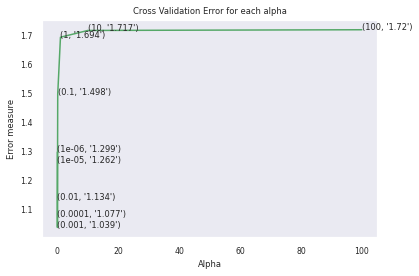

{'LogLoss': {'CV-loss': 1.0386823993844243,
             'Test-loss': 1.2498908956085881,
             'Train-loss': 0.49993420572966746},
 'Tuning': {1e-06: 1.2985723068237873,
            1e-05: 1.2619267460647434,
            0.0001: 1.0772823060148042,
            0.001: 1.0386823993844243,
            0.01: 1.134142730034016,
            0.1: 1.4977378008832536,
            1: 1.6941297505337642,
            10: 1.7174718103255033,
            100: 1.7199035894303853}}


In [19]:
# Logistic regression = SGD with LOGLOSS
balanced_logreg_dict = {}
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
hyperparam_dict = {}
# Refer: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

# Weights associated with classes. If not given, all classes are supposed to have weight one.
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional
# to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=random_state)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    hyperparam_dict[i] = log_loss(cv_y, sig_clf_probs)
balanced_logreg_dict["Tuning"] = hyperparam_dict

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=random_state)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

balanced_logreg_dict["LogLoss"] = loss_dict 
pprint(balanced_logreg_dict,compact=True)


<h6>3.1.2. Testing the model with best hyper paramters</h6>

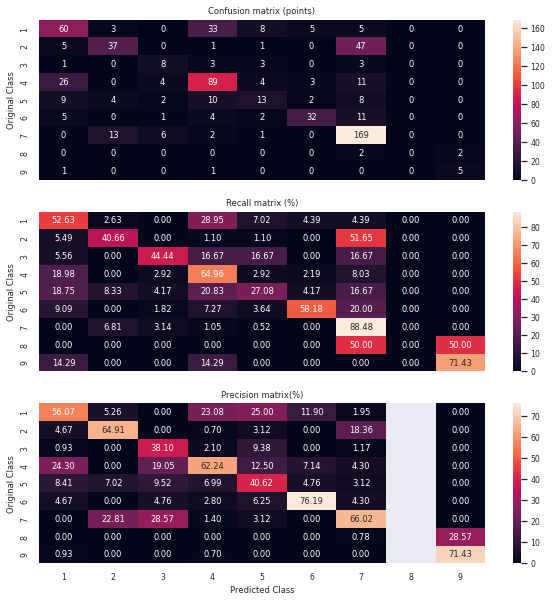

In [20]:
best_parameters = {}
best_parameters['Alpha'] = best_alpha

# Refer SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=random_state)
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           clf)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
balanced_logreg_dict["best_parameters"] = best_parameters

plot_confusion_matrix(test_y, pred_y)

<h6>3.1.3. Feature Importance</h6>

In [21]:
# Model fitting
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=random_state)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
balanced_logreg_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h6>Correctly Classified point</h6>

In [22]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)


Predicted Class :7
Class       1       2       3      4       5       6       7       8       9
Prob   0.0197  0.0151  0.0004  0.006  0.0017  0.0008  0.9511  0.0045  0.0007
Actual Class : 7
'>>> Out of the top 500 features 18 are present in query point'
'Features present in Top 500'
{'Gene': {},
 'Text': {38: 'constitutive',
          49: 'constitutively',
          71: 'transforming',
          81: 'transformation',
          170: 'subcutaneously',
          207: 'activation',
          219: 'transform',
          231: 'elicited',
          297: 'environment',
          312: 'activated',
          329: 'serum',
          349: 'oncogene',
          413: 'receptor',
          422: 'injection',
          464: 'transformed',
          467: 'oncogenes',
          473: 'murine',
          481: 'routines'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 18'
--------------------------------------------------


<h6>Mis-Classified point</h6>

In [23]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)

Predicted Class :7
Class       1       2      3       4      5       6      7       8       9
Prob   0.0165  0.1196  0.005  0.0158  0.344  0.0088  0.482  0.0056  0.0028
Actual Class : 2
'>>> Out of the top 500 features 7 are present in query point'
'Features present in Top 500'
{'Gene': {},
 'Text': {71: 'transforming',
          81: 'transformation',
          204: 'experienced',
          207: 'activation',
          223: 'musculoskeletal',
          312: 'activated',
          329: 'serum'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 7'
--------------------------------------------------


In [24]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_LOGREG_BALANCED.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_LOGREG_BALANCED.pkl")

balanced_logreg_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_LOGREG_BALANCED.pkl",\
                      "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_LOGREG_BALANCED.pkl"}

all_model_metadata["LOGREG_BALANCED"] = balanced_logreg_dict

In [25]:
pprint(balanced_logreg_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14,
                                            16, 17, 18, 19, 20, 21, 22, 23, 24,
                                            28, 29, 30, 33, 34, 35, 36, 37, 38,
                                            40, 41, 44, 46, 50, 52, 55, 56, 59,
                                            61, 64, 66, 68, 69, 72, 73, 74, 75,
                                            76, 78, 79, 81, 84, 86, 89, 90, 91,
                                            92, 94, 96, 100, 101, 103, 105, 107,
                                            108, 112, 113, 114, 116, 118, 122,
                                            123, 124, 125, 127, 128, 129, 130,
                                            132, 133, 137, 138, 141, 144, 145,
                                            146, 147, 148, 152, 153, 154, 155,
                                            157, 158, 159, 160, 161, 162, 163,
                                            

<h5>3.2. Without Class balancing</h5>

<h6>3.2.1. Hyper paramter tuning</h6>

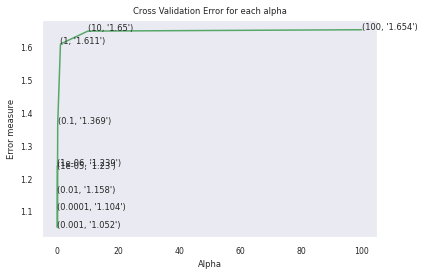

{'LogLoss': {'CV-loss': 1.0515987393490545,
             'Test-loss': 1.252125780762447,
             'Train-loss': 0.4968576736920199},
 'Tuning': {1e-06: 1.2390966839484001,
            1e-05: 1.2304017902750906,
            0.0001: 1.1042141897473658,
            0.001: 1.0515987393490545,
            0.01: 1.1578152225767708,
            0.1: 1.3685919843746281,
            1: 1.6105538393448655,
            10: 1.649877814961876,
            100: 1.6540041655077355}}


In [26]:
unbalanced_logreg_dict = {}
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
hyperparam_dict = {}
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=random_state)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    hyperparam_dict[i] = log_loss(cv_y, sig_clf_probs)
unbalanced_logreg_dict["Tuning"] = hyperparam_dict

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=random_state)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

unbalanced_logreg_dict["LogLoss"] = loss_dict 
pprint(unbalanced_logreg_dict,compact=True)


<h6>3.2.2. Testing model with best hyper parameters</h6>

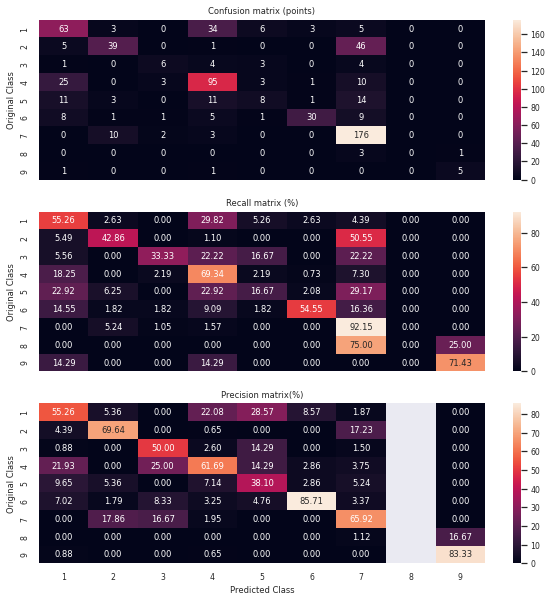

In [27]:
best_parameters = {}
best_parameters['Alpha'] = best_alpha

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=random_state)
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           clf)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
unbalanced_logreg_dict["best_parameters"] = best_parameters

plot_confusion_matrix(test_y, pred_y)

<h6>3.1.3. Feature Importance</h6>

In [28]:
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
unbalanced_logreg_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h6>Correctly Classified point</h6>

In [29]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)


Predicted Class :2
Class       1       2       3       4       5       6       7       8    9
Prob   0.0007  0.6965  0.0001  0.0002  0.0004  0.0002  0.2985  0.0034  0.0
Actual Class : 2
'>>> Out of the top 500 features 5 are present in query point'
'Features present in Top 500'
{'Gene': {},
 'Text': {132: 'leiomyosarcomas',
          289: 'predisease',
          294: '556',
          312: '573',
          400: 'contraindicated'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 5'
--------------------------------------------------


<h6>Inorrectly Classified point</h6>

In [30]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)

Predicted Class :1
Class       1       2       3       4       5       6       7       8       9
Prob   0.5316  0.0811  0.0018  0.2661  0.0149  0.0066  0.0889  0.0089  0.0001
Actual Class : 4
'>>> Out of the top 500 features 2 are present in query point'
'Features present in Top 500'
{'Gene': {}, 'Text': {447: 'ago', 478: 'mediator'}, 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 2'
--------------------------------------------------


In [31]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_LOGREG_UNBALANCED.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_LOGREG_UNBALANCED.pkl")

unbalanced_logreg_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_LOGREG_UNBALANCED.pkl",\
                                    "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_LOGREG_UNBALANCED.pkl"}

all_model_metadata["LOGREG_UNBALANCED"] = unbalanced_logreg_dict

In [32]:
pprint(unbalanced_logreg_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14,
                                            16, 17, 18, 19, 20, 21, 22, 23, 24,
                                            28, 29, 30, 32, 33, 34, 35, 36, 37,
                                            38, 40, 41, 42, 43, 44, 46, 48, 50,
                                            52, 55, 56, 59, 61, 62, 64, 66, 68,
                                            69, 72, 73, 74, 75, 76, 78, 79, 81,
                                            83, 84, 85, 86, 87, 89, 90, 91, 92,
                                            94, 96, 100, 101, 103, 105, 107,
                                            108, 112, 113, 114, 116, 118, 122,
                                            123, 124, 125, 127, 128, 129, 130,
                                            132, 133, 137, 138, 141, 144, 145,
                                            146, 147, 148, 152, 153, 154, 155,
                                            157

<h3>4. Support Vector Machines</h3>

<h5>4.1. Hyper paramter tuning</h5>

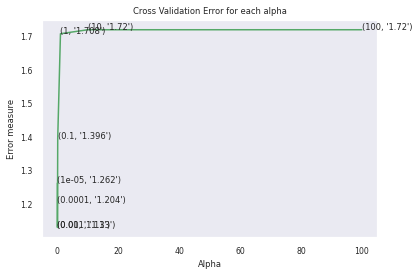

{'LogLoss': {'CV-loss': 1.1296850442092028,
             'Test-loss': 1.3009109278847517,
             'Train-loss': 0.7018998353067409},
 'Tuning': {1e-05: 1.2622034905639408,
            0.0001: 1.2038354829300157,
            0.001: 1.1296852997000864,
            0.01: 1.1296850442092028,
            0.1: 1.3961909404178023,
            1: 1.7083921907477952,
            10: 1.7202649441897169,
            100: 1.720264918967193}}


In [33]:
# REFER: SVM with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# SVM = SGD with hinge loss [not always]
svm_dict = {}
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
hyperparam_dict = {}
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=random_state)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    hyperparam_dict[i] = log_loss(cv_y, sig_clf_probs)
svm_dict["Tuning"] = hyperparam_dict

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()


best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=random_state)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

svm_dict["LogLoss"] = loss_dict 
pprint(svm_dict,compact=True)

<h5>4.2. Testing model with best hyper parameters</h5>

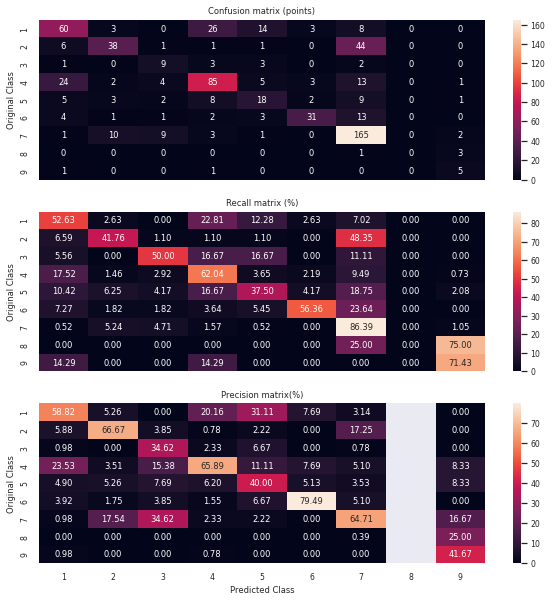

In [34]:
best_parameters = {}
best_parameters['Alpha'] = best_alpha

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', random_state=random_state,class_weight='balanced')
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           clf)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
svm_dict["best_parameters"] = best_parameters

plot_confusion_matrix(test_y, pred_y)

<h6>4.3. Feature Importance</h6>

In [35]:
# Model fitting
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=random_state)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
svm_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h5>4.3.1. For Correctly classified point</h5>

In [36]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)


Predicted Class :7
Class       1       2       3       4       5       6       7       8       9
Prob   0.0671  0.3332  0.0111  0.0889  0.0529  0.0533  0.3824  0.0053  0.0057
Actual Class : 7
'>>> Out of the top 500 features 8 are present in query point'
'Features present in Top 500'
{'Gene': {},
 'Text': {24: 'constitutive',
          71: 'constitutively',
          101: 'receptors',
          238: 'activation',
          313: '124',
          328: 'intrinsic',
          405: 'phosphotyrosine',
          417: 'activated'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 8'
--------------------------------------------------


<h5>4.3.2. For Mis-classified point</h5>

In [37]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)

Predicted Class :7
Class      1       2       3       4       5       6       7       8       9
Prob   0.076  0.1423  0.0057  0.1272  0.0315  0.0192  0.5908  0.0044  0.0029
Actual Class : 2
'>>> Out of the top 500 features 17 are present in query point'
'Features present in Top 500'
{'Gene': {},
 'Text': {24: 'constitutive',
          71: 'constitutively',
          100: 'oncogene',
          101: 'receptors',
          109: 'hyperplasia',
          171: 'downstream',
          189: 'murine',
          238: 'activation',
          247: 'thrombocytosis',
          268: 'intravenously',
          318: 'transformed',
          343: 'transformation',
          397: 'term',
          406: 'serum',
          425: 'plateau',
          468: 'injection',
          498: 'malignant'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 17'
--------------------------------------------------


In [38]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_SVM.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_SVM.pkl")

svm_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_SVM.pkl",\
                      "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_SVM.pkl"}

all_model_metadata["SVM"] = svm_dict

In [39]:
pprint(svm_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14,
                                            16, 17, 18, 19, 20, 21, 22, 24, 25,
                                            29, 30, 32, 33, 34, 35, 36, 37, 38,
                                            41, 44, 46, 50, 52, 55, 56, 59, 61,
                                            64, 66, 68, 69, 72, 74, 75, 76, 78,
                                            79, 81, 84, 86, 88, 89, 90, 91, 92,
                                            94, 96, 100, 101, 103, 105, 107,
                                            108, 112, 113, 114, 116, 118, 122,
                                            123, 124, 125, 127, 128, 129, 130,
                                            132, 133, 137, 138, 141, 144, 146,
                                            147, 148, 152, 153, 154, 155, 157,
                                            158, 159, 160, 161, 162, 163, 164,
                                            165,

<h3>5. Random Forest Classifier</h3>

<h4>With One hot Encoding</h4>

In [40]:
# Issues with pandas version 0.23 with Parellelism
# https://github.com/scikit-learn/scikit-learn/issues/15851#issuecomment-564015275
# Setting n_jobs=1 will fix it for now.

<h5>5.1. Hyper paramter tuning</h5>

In [41]:
rf_ohe_dict = {}
estimators = [10,50,100,200,500,1000,2000]
max_depth = [2,3,5,10]
cv_log_error_array = []
hyperparam_dict = {}

for i in estimators:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=random_state,n_jobs=1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        hyperparam_dict[(i,j)] = log_loss(cv_y, sig_clf_probs)
rf_ohe_dict["Tuning"] = hyperparam_dict

# Note here it is just idx not param so while saving keep an eye
min_loss_value = min(cv_log_error_array)

minloss_pairs = [tup for tup in hyperparam_dict if hyperparam_dict[tup] == min_loss_value]
best_estimators = minloss_pairs[0][0] 
best_max_depth = minloss_pairs[0][1] 

clf = RandomForestClassifier(n_estimators=best_estimators, criterion='gini', max_depth=best_max_depth, random_state=random_state,n_jobs=1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

rf_ohe_dict["LogLoss"] = loss_dict 
pprint(rf_ohe_dict,compact=True)


{'LogLoss': {'CV-loss': 1.130409901342001,
             'Test-loss': 1.2193662507499525,
             'Train-loss': 0.6780887941957467},
 'Tuning': {(10, 2): 1.487580387480708,
            (10, 3): 1.4472304264776914,
            (10, 5): 1.3625054801313445,
            (10, 10): 1.257314563894566,
            (50, 2): 1.375075119549827,
            (50, 3): 1.3207547199791048,
            (50, 5): 1.2586791835942497,
            (50, 10): 1.1645662005677224,
            (100, 2): 1.3657919497924347,
            (100, 3): 1.3156845259900358,
            (100, 5): 1.2419338582549437,
            (100, 10): 1.1552025916842674,
            (200, 2): 1.3436765734503202,
            (200, 3): 1.2970702328217847,
            (200, 5): 1.235158772512107,
            (200, 10): 1.14132684235058,
            (500, 2): 1.339818374840174,
            (500, 3): 1.286016572101533,
            (500, 5): 1.2166371557359321,
            (500, 10): 1.133952648470288,
            (1000, 2): 1.3355428521

<h5>5.2. Testing model with best hyper parameters (One Hot Encoding)</h5>

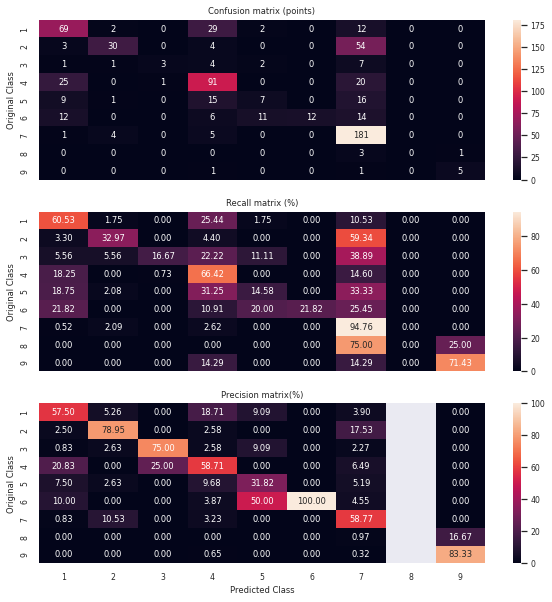

In [42]:
best_parameters = {}
best_parameters['n_estimators'] = best_estimators
best_parameters['max_depth'] = best_max_depth

clf = RandomForestClassifier(n_estimators=best_estimators, criterion='gini', max_depth=best_max_depth, random_state=random_state, n_jobs=1)
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           clf)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
rf_ohe_dict["best_parameters"] = best_parameters

plot_confusion_matrix(test_y, pred_y)

<h5>5.3. Feature Importance</h5>

In [43]:
# Model fitting
clf = RandomForestClassifier(n_estimators=best_estimators, criterion='gini', max_depth=best_max_depth, random_state=random_state,n_jobs=1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
rf_ohe_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

<h6>Correctly Classified point</h6>

In [44]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-clf.feature_importances_)

get_impfeature_names(indices[:no_feature], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)


Predicted Class :1
Class       1       2       3       4      5      6       7       8       9
Prob   0.7047  0.0384  0.0145  0.0712  0.041  0.034  0.0846  0.0056  0.0059
Actual Class : 1
'>>> Out of the top 100 features 36 are present in query point'
'Features present in Top 100'
{'Gene': {},
 'Text': {0: 'kinase',
          1: 'activating',
          2: 'activation',
          3: 'activated',
          4: 'tyrosine',
          7: 'function',
          8: 'phosphorylation',
          10: 'inhibitor',
          14: 'signaling',
          15: 'treatment',
          18: 'stability',
          19: 'drug',
          20: 'functional',
          21: 'kinases',
          24: 'receptor',
          27: 'loss',
          29: 'growth',
          35: 'transforming',
          36: 'activate',
          37: 'defective',
          39: 'constitutively',
          44: 'variants',
          45: 'proliferation',
          46: 'extracellular',
          51: 'treated',
          52: 'cell',
          53: '

<h6>Mis-Classified point</h6>

In [45]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices=np.argsort(-clf.feature_importances_)

get_impfeature_names(indices[:no_feature], \
                     test_df['Text'].iloc[test_point_index],\
                     test_df['Gene'].iloc[test_point_index],\
                     test_df['Variation'].iloc[test_point_index], \
                     no_feature, \
                     train_df)

Predicted Class :1
Class       1       2       3       4       5       6       7       8       9
Prob   0.5861  0.0372  0.0153  0.2153  0.0479  0.0399  0.0433  0.0066  0.0084
Actual Class : 4
'>>> Out of the top 100 features 15 are present in query point'
'Features present in Top 100'
{'Gene': {},
 'Text': {6: 'suppressor',
          7: 'function',
          27: 'loss',
          28: 'yeast',
          29: 'growth',
          44: 'variants',
          52: 'cell',
          55: 'cells',
          61: 'variant',
          69: 'response',
          73: 'expression',
          84: 'transformation',
          88: 'proteins',
          89: 'protein',
          99: 'p53'},
 'Variantion': {}}
'Numuber of features from Gene features: 0 | Variation: 0 | Text: 15'
--------------------------------------------------


In [46]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_RF_OHE.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_RF_OHE.pkl")

rf_ohe_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_RF_OHE.pkl",\
                         "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_RF_OHE.pkl"}

all_model_metadata["Random-Forest_with_OHE"] = rf_ohe_dict

In [47]:
pprint(rf_ohe_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14,
                                            16, 17, 18, 19, 20, 21, 22, 23, 24,
                                            28, 29, 30, 32, 33, 34, 35, 36, 37,
                                            40, 41, 42, 43, 44, 45, 46, 48, 49,
                                            50, 56, 61, 66, 68, 69, 71, 72, 73,
                                            75, 76, 78, 79, 81, 83, 84, 85, 87,
                                            88, 89, 90, 91, 92, 94, 96, 97, 100,
                                            101, 103, 105, 108, 111, 113, 114,
                                            116, 118, 121, 122, 123, 124, 125,
                                            127, 128, 129, 131, 132, 133, 136,
                                            137, 138, 141, 146, 147, 148, 152,
                                            153, 154, 155, 157, 159, 160, 161,
                                           

<h4>With Response Coding</h4>

<h5>5.1. Hyper paramter tuning</h5>

In [48]:
rf_rc_dict = {}
estimators = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
hyperparam_dict = {}

for i in estimators:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=random_state, n_jobs=1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        hyperparam_dict[(i,j)] = log_loss(cv_y, sig_clf_probs)
rf_rc_dict["Tuning"] = hyperparam_dict

# Note here it is just idx not param so while saving keep an eye
min_loss_value = min(cv_log_error_array)

minloss_pairs = [tup for tup in hyperparam_dict if hyperparam_dict[tup] == min_loss_value]
best_estimators = minloss_pairs[0][0] 
best_max_depth = minloss_pairs[0][1] 

clf = RandomForestClassifier(n_estimators=best_estimators, criterion='gini', max_depth=best_max_depth, random_state=random_state, n_jobs=1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


loss_dict = {}
predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

rf_rc_dict["LogLoss"] = loss_dict 
pprint(rf_rc_dict,compact=True)

{'LogLoss': {'CV-loss': 0.06902056358992315,
             'Test-loss': 0.06795731634201913,
             'Train-loss': 0.034371000287393566},
 'Tuning': {(10, 2): 0.30816898874085646,
            (10, 3): 0.235087408402514,
            (10, 5): 0.09974122897215328,
            (10, 10): 0.07741394946680838,
            (50, 2): 0.22947867911170847,
            (50, 3): 0.16834893702281636,
            (50, 5): 0.09499852642266063,
            (50, 10): 0.07145587299857699,
            (100, 2): 0.23961972256655586,
            (100, 3): 0.1629458913298638,
            (100, 5): 0.08911127896188828,
            (100, 10): 0.0700836695155292,
            (200, 2): 0.20852893538487105,
            (200, 3): 0.148726789767899,
            (200, 5): 0.08708271485671247,
            (200, 10): 0.06982220147413742,
            (500, 2): 0.19423958688123583,
            (500, 3): 0.148061711598416,
            (500, 5): 0.08752257394310811,
            (500, 10): 0.06968685958315815,
         

<h5>5.2. Testing model with best hyper parameters</h5>

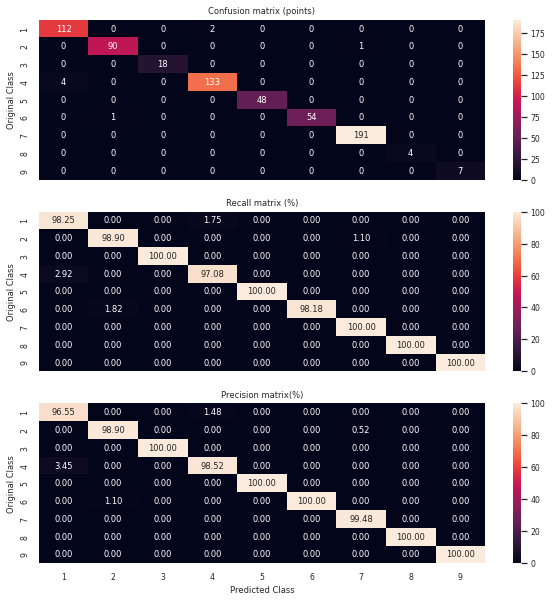

In [49]:
best_parameters = {}
best_parameters['n_estimators'] = best_estimators
best_parameters['max_depth'] = best_max_depth

clf = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_estimators, criterion='gini', max_features='auto',random_state=random_state,n_jobs=1)
logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_responseCoding, \
                                                                                           train_y, \
                                                                                           test_x_responseCoding, \
                                                                                           test_y, \
                                                                                           clf)

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points
rf_rc_dict["best_parameters"] = best_parameters

plot_confusion_matrix(test_y, pred_y)


<h5>5.3. Feature Importance</h5>

In [50]:
# Model fitting
clf = RandomForestClassifier(n_estimators=best_estimators, criterion='gini', max_depth=best_max_depth, random_state=random_state, n_jobs=1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sig_clf.predict(test_x_responseCoding)
total_test_points = test_x_responseCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
rf_rc_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}


<h5>Correctly Classified point</h5>

In [51]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 27   # 9 classes * 3 number of features

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("At {0} Gene is important feature".format(i))
    elif i<18:
        print("At {0} Variation is important feature".format(i))
    else:
        print("At {0} Text is important feature".format(i))

Predicted Class :6
Class       1       2       3       4       5       6       7       8       9
Prob   0.0035  0.0041  0.0032  0.0045  0.0031  0.9714  0.0043  0.0031  0.0029
Actual Class : 6
--------------------------------------------------
At 15 Variation is important feature
At 9 Variation is important feature
At 12 Variation is important feature
At 10 Variation is important feature
At 13 Variation is important feature
At 14 Variation is important feature
At 6 Gene is important feature
At 24 Text is important feature
At 21 Text is important feature
At 19 Text is important feature
At 18 Text is important feature
At 3 Gene is important feature
At 11 Variation is important feature
At 23 Text is important feature
At 0 Gene is important feature
At 1 Gene is important feature
At 22 Text is important feature
At 5 Gene is important feature
At 17 Variation is important feature
At 20 Text is important feature
At 26 Text is important feature
At 4 Gene is important feature
At 16 Variation is i

<h5> Misclassified point</h5>

In [52]:
test_point_index = random.choice(misclassified_point_idxs)

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("At {0} Gene is important feature".format(i))
    elif i<18:
        print("At {0} Variation is important feature".format(i))
    else:
        print("At {0} Text is important feature".format(i))
        

Predicted Class :1
Class       1       2       3      4       5      6       7       8       9
Prob   0.7824  0.0048  0.0035  0.189  0.0036  0.005  0.0048  0.0036  0.0034
Actual Class : 4
--------------------------------------------------
At 15 Variation is important feature
At 9 Variation is important feature
At 12 Variation is important feature
At 10 Variation is important feature
At 13 Variation is important feature
At 14 Variation is important feature
At 6 Gene is important feature
At 24 Text is important feature
At 21 Text is important feature
At 19 Text is important feature
At 18 Text is important feature
At 3 Gene is important feature
At 11 Variation is important feature
At 23 Text is important feature
At 0 Gene is important feature
At 1 Gene is important feature
At 22 Text is important feature
At 5 Gene is important feature
At 17 Variation is important feature
At 20 Text is important feature
At 26 Text is important feature
At 4 Gene is important feature
At 16 Variation is impor

In [53]:
# Saving metadata and model
joblib.dump(clf,MODELS_DIR+"base_RF_RC.pkl")
joblib.dump(sig_clf,MODELS_DIR+"calibrated_RF_RC.pkl")

rf_rc_dict["Models"] = {"base_classifier"       : MODELS_DIR[1:]+"base_RF_RC.pkl",\
                        "calibrated_classifier" : MODELS_DIR[1:]+"calibrated_RF_RC.pkl"}

all_model_metadata["Random-Forest_with_RC"] = rf_rc_dict

In [54]:
pprint(rf_rc_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                            11, 12, 13, 14, 15, 16, 17, 18, 19,
                                            20, 21, 22, 23, 24, 25, 26, 27, 28,
                                            29, 30, 31, 32, 33, 34, 35, 36, 37,
                                            38, 39, 40, 41, 42, 43, 44, 45, 46,
                                            47, 48, 49, 50, 51, 52, 53, 54, 55,
                                            56, 57, 58, 59, 60, 61, 62, 63, 64,
                                            65, 66, 67, 68, 69, 70, 71, 72, 73,
                                            74, 75, 76, 77, 78, 79, 80, 81, 82,
                                            83, 84, 85, 86, 87, 88, 89, 90, 91,
                                            92, 93, 94, 95, 96, 97, 98, 99, 100,
                                            101, 102, 103, 104, 105, 106, 107,
                                          

<h3>6. Models Stacking </h3>

<h4>6.1 Testing with hyper parameter tuning</h4>

In [55]:
stacked_dict = {}

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=random_state)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=random_state)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
LR_logloss = log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))

sig_clf2.fit(train_x_onehotCoding, train_y)
SVM_logloss = log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))

sig_clf3.fit(train_x_onehotCoding, train_y)
NB_logloss = log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))

stacked_dict["base_classifiers"] = {\
    'clf1' : {'alpha':0.001, 'name':'Logistic Regression', 'logloss': LR_logloss},\
    'clf2' : {'alpha':1, 'name':'SVM', 'logloss': SVM_logloss},\
    'clf3' : {'alpha':0.001, 'name':'MultinomialNB', 'logloss': NB_logloss}                            
}

# Tuning the stacking of all three models with alpha where meta classifier will be LR.
alpha = [0.0001,0.001,0.01,0.1,1,10] 
minloss = float('inf')
best_alpha = alpha[0]
hyperparam_dict = {}
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    stacked_logloss =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    hyperparam_dict[(i,j)] = stacked_logloss


    if stacked_logloss < best_alpha:
        minloss = stacked_logloss
        best_alpha = i
        
stacked_dict["Tuning"] = hyperparam_dict
pprint(stacked_dict,compact=True)

{'Tuning': {(0.0001, 10): 1.817204020292249,
            (0.001, 10): 1.713399321898598,
            (0.01, 10): 1.2860827307472082,
            (0.1, 10): 1.0788271067576922,
            (1, 10): 1.2761059057228732,
            (10, 10): 1.540532806084656},
 'base_classifiers': {'clf1': {'alpha': 0.001,
                               'logloss': 1.0386823993844243,
                               'name': 'Logistic Regression'},
                      'clf2': {'alpha': 1,
                               'logloss': 1.7083921907477952,
                               'name': 'SVM'},
                      'clf3': {'alpha': 0.001,
                               'logloss': 1.2421093844828208,
                               'name': 'MultinomialNB'}}}


<h4>6.2 testing the model with the best hyper parameters</h4>

In [56]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

loss_dict = {}
train_loss = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
cv_loss = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
test_loss = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))

loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss

stacked_dict["LogLoss"] = loss_dict 

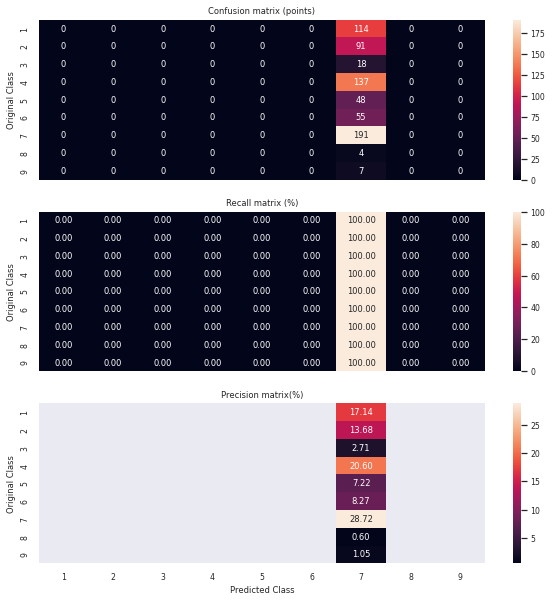

In [57]:
best_parameters = {}
best_parameters['Alpha'] = best_alpha

# logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
#                                                                                            train_y, \
#                                                                                            test_x_onehotCoding, \
#                                                                                            test_y, \
#                                                                                            sclf)

sig_clf_probs = sclf.predict_proba(test_x_onehotCoding)
pred_y = sclf.predict(test_x_onehotCoding)

logloss = log_loss(test_y, sig_clf_probs, eps=1e-15)
misclassfied_points = np.count_nonzero((pred_y - test_y))/test_y.shape[0]

best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points

stacked_dict['best_parameters'] = best_parameters

plot_confusion_matrix(test_y, pred_y)
# print(test_y)
# print(pred_y)

<h5>5.3. Feature Importance</h5>
For ensemble type models, interpretability is little bit difficult to get.

In [58]:
# Model fitting
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = sclf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)
stacked_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}


<h5>Correctly Classified point</h5>

In [59]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 100

predicted_cls = sclf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sclf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))

# Ensemble so no feature_importances_
# indices=np.argsort(-sclf.feature_importances_)
# get_impfeature_names(indices[:no_feature], \
#                      test_df['Text'].iloc[test_point_index],\
#                      test_df['Gene'].iloc[test_point_index],\
#                      test_df['Variation'].iloc[test_point_index], \
#                      no_feature, \
#                      train_df)

Predicted Class :7
Class       1      2       3       4      5       6       7       8       9
Prob   0.1701  0.137  0.0268  0.2051  0.073  0.0827  0.2883  0.0057  0.0113
Actual Class : 7


<h5> Misclassified point</h5>

In [60]:
test_point_index = random.choice(misclassified_point_idxs)
no_feature = 100

predicted_cls = sclf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sclf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))

# Ensemble so no feature_importances_
# indices=np.argsort(-sclf.feature_importances_)
# get_impfeature_names(indices[:no_feature], \
#                      test_df['Text'].iloc[test_point_index],\
#                      test_df['Gene'].iloc[test_point_index],\
#                      test_df['Variation'].iloc[test_point_index], \
#                      no_feature, \
#                      train_df)

Predicted Class :7
Class       1       2       3       4      5       6       7       8       9
Prob   0.1704  0.1355  0.0268  0.2121  0.073  0.0828  0.2825  0.0057  0.0113
Actual Class : 4


In [61]:
# Saving metadata and model
joblib.dump(sclf,MODELS_DIR+"base_STACKED_CLASSIFIER.pkl")

stacked_dict["Models"] = {"base_classifier" : MODELS_DIR[1:]+"base_STACKED_CLASSIFIER.pkl"}

all_model_metadata["Stacked-Classifier"] = stacked_dict

In [62]:
pprint(stacked_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [2, 3, 4, 14, 17, 18, 23, 28, 32, 36,
                                            37, 41, 42, 45, 46, 48, 50, 54, 55,
                                            56, 61, 72, 75, 77, 78, 79, 81, 89,
                                            90, 92, 94, 101, 108, 113, 116, 118,
                                            121, 123, 124, 129, 132, 137, 138,
                                            147, 152, 154, 157, 159, 163, 170,
                                            171, 172, 173, 174, 184, 191, 194,
                                            197, 199, 200, 205, 206, 208, 219,
                                            224, 229, 230, 236, 239, 240, 242,
                                            243, 247, 249, 252, 255, 257, 261,
                                            262, 273, 274, 279, 280, 281, 283,
                                            287, 288, 295, 296, 299, 300, 301,
                                            30

<h4>6.3 Maximum Voting classifier </h4>

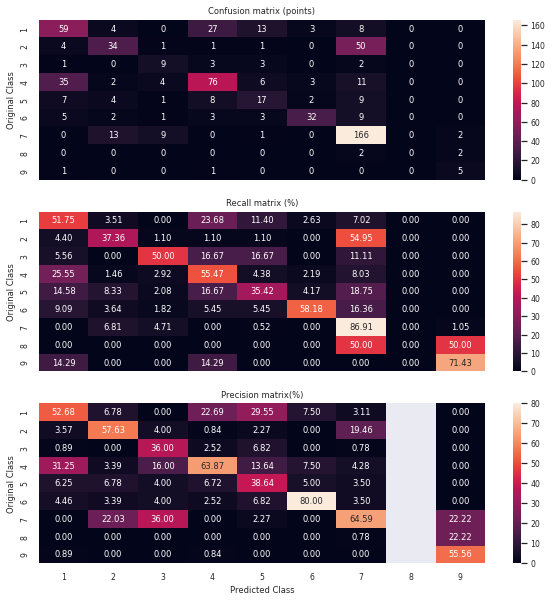

In [63]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
voting_dict = {}

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

train_loss = log_loss(train_y, vclf.predict_proba(train_x_onehotCoding))
cv_loss = log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding))
test_loss = log_loss(test_y, vclf.predict_proba(test_x_onehotCoding))

loss_dict = {}
loss_dict['Train-loss'] = train_loss
loss_dict['CV-loss'] = cv_loss
loss_dict['Test-loss'] = test_loss


logloss, misclassfied_points, pred_y = report_log_loss_and_misclassified_points_and_pred_y(train_x_onehotCoding, \
                                                                                           train_y, \
                                                                                           test_x_onehotCoding, \
                                                                                           test_y, \
                                                                                           vclf)
best_parameters = {}
best_parameters["LogLoss"] = logloss
best_parameters["Misclassified-Percent"] = misclassfied_points

voting_dict['LogLoss'] = loss_dict
voting_dict['best_parameters'] = best_parameters

plot_confusion_matrix(test_y, pred_y)

In [64]:
# Model fitting
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

# Getting correct & incorrect classifications
correctly_classified_point_idxs = []
misclassified_point_idxs = []

predictions = vclf.predict(test_x_onehotCoding)
total_test_points = test_x_onehotCoding.shape[0]
for i in range(total_test_points):
    if test_y[i] == predictions[i]:
        correctly_classified_point_idxs.append(i)
    else:
        misclassified_point_idxs.append(i)

voting_dict["Classified-Test-Datapoints"] ={ "Correct": correctly_classified_point_idxs, "Misclassified":  misclassified_point_idxs}

In [65]:
test_point_index = random.choice(correctly_classified_point_idxs)
no_feature = 100

predicted_cls = sclf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :{0}".format(predicted_cls[0]))

pred_class_probabilties = np.round(sclf.predict_proba(test_x_onehotCoding[test_point_index]),4)
prob_df = pd.DataFrame.from_dict({"Class" : [int(i) for i in range(1,len(pred_class_probabilties[0])+1)],\
                                  "Prob":pred_class_probabilties[0]})
print(prob_df.set_index('Class').T)
print("Actual Class : {0}".format(test_y[test_point_index]))

# Ensemble so no feature_importances_
# indices=np.argsort(-sclf.feature_importances_)
# get_impfeature_names(indices[:no_feature], \
#                      test_df['Text'].iloc[test_point_index],\
#                      test_df['Gene'].iloc[test_point_index],\
#                      test_df['Variation'].iloc[test_point_index], \
#                      no_feature, \
#                      train_df)

Predicted Class :7
Class       1       2       3       4       5       6       7       8       9
Prob   0.1713  0.1363  0.0269  0.2068  0.0731  0.0829  0.2858  0.0057  0.0113
Actual Class : 7


In [66]:
# Saving metadata and model
joblib.dump(vclf,MODELS_DIR+"base_VOTING_CLASSIFIER.pkl")

voting_dict["Models"] = {"base_classifier" : MODELS_DIR[1:]+"base_VOTING_CLASSIFIER.pkl"}

all_model_metadata["VOTING-Classifier"] = voting_dict

In [67]:
pprint(voting_dict,compact=True)

{'Classified-Test-Datapoints': {'Correct': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14,
                                            16, 17, 18, 19, 20, 21, 22, 23, 24,
                                            25, 28, 29, 30, 33, 34, 35, 36, 37,
                                            38, 41, 44, 46, 50, 54, 55, 56, 59,
                                            61, 64, 65, 66, 68, 69, 72, 75, 76,
                                            77, 78, 79, 81, 84, 86, 87, 88, 90,
                                            91, 92, 94, 96, 100, 101, 103, 105,
                                            107, 108, 112, 113, 114, 116, 118,
                                            122, 123, 124, 125, 127, 128, 129,
                                            130, 131, 132, 133, 137, 138, 144,
                                            145, 146, 147, 148, 152, 153, 154,
                                            155, 157, 159, 160, 161, 163, 164,
                                            1

<h3>Final Metadata</h3>

In [68]:
pprint(all_model_metadata,compact=True)

{'KNN': {'Classified-Test-Datapoints': {'Correct': [0, 1, 2, 3, 4, 6, 7, 9, 10,
                                                    11, 14, 16, 17, 18, 20, 21,
                                                    22, 23, 24, 25, 26, 27, 28,
                                                    29, 31, 32, 33, 36, 37, 38,
                                                    41, 42, 44, 45, 46, 48, 49,
                                                    50, 51, 52, 53, 55, 56, 59,
                                                    61, 62, 65, 66, 67, 68, 69,
                                                    72, 74, 75, 76, 78, 79, 80,
                                                    81, 84, 85, 86, 87, 88, 89,
                                                    90, 91, 92, 93, 94, 95, 96,
                                                    100, 101, 103, 105, 106,
                                                    108, 111, 113, 114, 117,
                                              

In [69]:
# import joblib
# from pprint import pprint
# MODELS_DIR = "../models/"
# all_model_metadata = joblib.load(MODELS_DIR+"models_metadata.pkl")
# pprint(all_model_metadata, compact=True)

In [70]:
# Fixing issue of tuple being in key position and convert it to [hp1, hp2, logloss].

def fix_tuple_as_keys(list_model_tuning_tobe_fixed,original_metadata_dict):
    for model_key_name in list_model_tuning_tobe_fixed:
        d = original_metadata_dict[model_key_name]['Tuning']
        tuning_updated = []
        for tup in d:
            hp1, hp2 = tup
            logloss = d[tup]
            tuning_updated.append((hp1, hp2, logloss))
        
        original_metadata_dict[model_key_name]['Tuning'] = tuning_updated
    return original_metadata_dict
        
fix_list = ["Random-Forest_with_OHE", "Random-Forest_with_RC","Stacked-Classifier"]
all_model_metadata = fix_tuple_as_keys(fix_list, all_model_metadata)
pprint(all_model_metadata,compact=True)

{'KNN': {'Classified-Test-Datapoints': {'Correct': [0, 1, 2, 3, 4, 6, 7, 9, 10,
                                                    11, 14, 16, 17, 18, 20, 21,
                                                    22, 23, 24, 25, 26, 27, 28,
                                                    29, 31, 32, 33, 36, 37, 38,
                                                    41, 42, 44, 45, 46, 48, 49,
                                                    50, 51, 52, 53, 55, 56, 59,
                                                    61, 62, 65, 66, 67, 68, 69,
                                                    72, 74, 75, 76, 78, 79, 80,
                                                    81, 84, 85, 86, 87, 88, 89,
                                                    90, 91, 92, 93, 94, 95, 96,
                                                    100, 101, 103, 105, 106,
                                                    108, 111, 113, 114, 117,
                                              

In [71]:
joblib.dump(all_model_metadata, MODELS_DIR+"models_metadata.pkl")

['../models/models_metadata.pkl']

In [72]:
pprint(all_model_metadata,compact=True)

{'KNN': {'Classified-Test-Datapoints': {'Correct': [0, 1, 2, 3, 4, 6, 7, 9, 10,
                                                    11, 14, 16, 17, 18, 20, 21,
                                                    22, 23, 24, 25, 26, 27, 28,
                                                    29, 31, 32, 33, 36, 37, 38,
                                                    41, 42, 44, 45, 46, 48, 49,
                                                    50, 51, 52, 53, 55, 56, 59,
                                                    61, 62, 65, 66, 67, 68, 69,
                                                    72, 74, 75, 76, 78, 79, 80,
                                                    81, 84, 85, 86, 87, 88, 89,
                                                    90, 91, 92, 93, 94, 95, 96,
                                                    100, 101, 103, 105, 106,
                                                    108, 111, 113, 114, 117,
                                              

In [73]:
time_taken_mins = round((time.time() - start_time)/60,2)
print("Total time taken for executing this whole notebook is : {0} mins".format(time_taken_mins))

Total time taken for executing this whole notebook is : 57.55 mins
